## 6.4　LSTM を使った言語モデル

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/yuta.shimizu/Downloads/ML/deep-learning-from-scratch-2-master/ch06')
sys.path.append(os.pardir)

In [3]:
from dataset import ptb
from rnnlm import Rnnlm
from common.time_layers import *
from common.optimizer import SGD
from common.util import eval_perplexity
from common.trainer import RnnlmTrainer

In [4]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [5]:
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [6]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs  = corpus[:-1]
ts = corpus[1:]

In [7]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

`eval_interval=20` で、20 イテレーションごとに損失の平均を求め、その結果を出力する。<br>
`max_grad` は、勾配クリッピングのしきい値である。

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.66
| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 3110.49
| epoch 1 |  iter 41 / 1327 | time 10[s] | perplexity 1226.23
| epoch 1 |  iter 61 / 1327 | time 14[s] | perplexity 950.36
| epoch 1 |  iter 81 / 1327 | time 19[s] | perplexity 793.28
| epoch 1 |  iter 101 / 1327 | time 23[s] | perplexity 653.70
| epoch 1 |  iter 121 / 1327 | time 27[s] | perplexity 664.68
| epoch 1 |  iter 141 / 1327 | time 32[s] | perplexity 624.24
| epoch 1 |  iter 161 / 1327 | time 36[s] | perplexity 591.57
| epoch 1 |  iter 181 / 1327 | time 40[s] | perplexity 583.15
| epoch 1 |  iter 201 / 1327 | time 44[s] | perplexity 506.84
| epoch 1 |  iter 221 / 1327 | time 49[s] | perplexity 503.24
| epoch 1 |  iter 241 / 1327 | time 53[s] | perplexity 446.91
| epoch 1 |  iter 261 / 1327 | time 57[s] | perplexity 466.18
| epoch 1 |  iter 281 / 1327 | time 61[s] | perplexity 438.85
| epoch 1 |  iter 301 / 1327 | time 66[s] | perplexity 398.34
| epoch 1 | 

| epoch 2 |  iter 1281 / 1327 | time 568[s] | perplexity 122.45
| epoch 2 |  iter 1301 / 1327 | time 572[s] | perplexity 156.78
| epoch 2 |  iter 1321 / 1327 | time 576[s] | perplexity 150.75
| epoch 3 |  iter 1 / 1327 | time 578[s] | perplexity 160.93
| epoch 3 |  iter 21 / 1327 | time 582[s] | perplexity 144.62
| epoch 3 |  iter 41 / 1327 | time 587[s] | perplexity 135.98
| epoch 3 |  iter 61 / 1327 | time 591[s] | perplexity 128.10
| epoch 3 |  iter 81 / 1327 | time 595[s] | perplexity 117.04
| epoch 3 |  iter 101 / 1327 | time 600[s] | perplexity 105.55
| epoch 3 |  iter 121 / 1327 | time 604[s] | perplexity 115.72
| epoch 3 |  iter 141 / 1327 | time 608[s] | perplexity 126.76
| epoch 3 |  iter 161 / 1327 | time 613[s] | perplexity 143.06
| epoch 3 |  iter 181 / 1327 | time 617[s] | perplexity 151.38
| epoch 3 |  iter 201 / 1327 | time 621[s] | perplexity 140.40
| epoch 3 |  iter 221 / 1327 | time 626[s] | perplexity 140.30
| epoch 3 |  iter 241 / 1327 | time 630[s] | perplexity 13

| epoch 4 |  iter 1201 / 1327 | time 1126[s] | perplexity 84.71
| epoch 4 |  iter 1221 / 1327 | time 1130[s] | perplexity 75.64
| epoch 4 |  iter 1241 / 1327 | time 1134[s] | perplexity 91.62
| epoch 4 |  iter 1261 / 1327 | time 1139[s] | perplexity 94.37
| epoch 4 |  iter 1281 / 1327 | time 1143[s] | perplexity 89.19
| epoch 4 |  iter 1301 / 1327 | time 1148[s] | perplexity 110.93
| epoch 4 |  iter 1321 / 1327 | time 1152[s] | perplexity 110.00


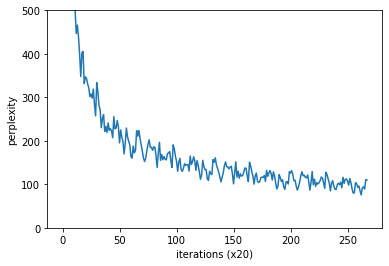

In [8]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

In [9]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

model.save_params()

evaluating perplexity ...
234 / 235
test perplexity:  136.9680765307647
